In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import os
import skimage.draw
import numpy as np
from tqdm import tqdm
import cv2
from glob import glob
import warnings
import random
warnings.filterwarnings('ignore')

%matplotlib inline

# Helpers

def create_directory(directory):
    '''
    Creates a new folder in the specified directory if the folder doesn't exist.
    INPUT
        directory: Folder to be created, called as "folder/".
    OUTPUT
        New folder in the current directory.
    '''
    if not os.path.exists(directory):
        os.makedirs(directory)
        
        
        
def read_nuclei(path):
    "Read raw data"

    # Load 4-channel image
    if len(path) == 0:
        return None
    
    img = skimage.io.imread(path)
    
    # input image
    if len(img.shape) > 2:
        img = img[:,:,:3]
    # mask
    else:
        # do nothing
        pass
        
    return img



def save_nuclei(path, img):
    "save image"
    skimage.io.imsave(path, img)
    
    
    
label_map = {'Epithelial':1,
             'Lymphocyte':2,
             'Macrophage':4,
             'Neutrophil':3,
            }


# Root directory of the project
ROOT_DIR = os.path.abspath("./")
print(ROOT_DIR)
# Training file directory
IMAGES_FOLDER = os.path.join(ROOT_DIR, "dataset", "Testing images/")
print(IMAGES_FOLDER)
IMAGES_SUB_FOLDER = [os.path.join(IMAGES_FOLDER, i) for i in sorted(next(os.walk(IMAGES_FOLDER))[1])]
print(IMAGES_SUB_FOLDER[:5])
IMAGES_DEST =  os.path.join(ROOT_DIR, "dataset", "test_images")
print(IMAGES_DEST)
# Create folders
create_directory(IMAGES_DEST)

/home/hasib/hasib/MoNuSAC-ISBI-2020
/home/hasib/hasib/MoNuSAC-ISBI-2020/dataset/Testing images/
['/home/hasib/hasib/MoNuSAC-ISBI-2020/dataset/Testing images/TCGA-2Z-A9JG-01Z-00-DX1', '/home/hasib/hasib/MoNuSAC-ISBI-2020/dataset/Testing images/TCGA-2Z-A9JN-01Z-00-DX1', '/home/hasib/hasib/MoNuSAC-ISBI-2020/dataset/Testing images/TCGA-49-6743-01Z-00-DX2', '/home/hasib/hasib/MoNuSAC-ISBI-2020/dataset/Testing images/TCGA-50-6591-01Z-00-DX1', '/home/hasib/hasib/MoNuSAC-ISBI-2020/dataset/Testing images/TCGA-55-7570-01Z-00-DX1']
/home/hasib/hasib/MoNuSAC-ISBI-2020/dataset/test_images


In [2]:
# STORE IMAGES in test folder together

raw_ct = 0
for ct in tqdm(range(len(IMAGES_SUB_FOLDER[:]))):
    
    #print(ct)
    
    # Read all raw images in image sub folder
    all_imgs = sorted(glob(IMAGES_SUB_FOLDER[ct] + '/*.tif'))
    
    paths = [s.split('.')[0][-25:] for s in all_imgs]
    
    
    # Iterate over the individual raw images
    for i in range(len(all_imgs)):
        
        # Read test image
        #print(all_imgs[i])
        img = read_nuclei(all_imgs[i])

        # Save it
        save_nuclei(IMAGES_DEST+ "/{}.png".format(paths[i]), img)
        raw_ct+=1

100%|██████████| 25/25 [00:13<00:00,  1.83it/s]


In [3]:
image_fns = sorted(next(os.walk(IMAGES_DEST))[2])
image_fns[:3]

['GA-49-6743-01Z-00-DX2_001.png',
 'GA-49-6743-01Z-00-DX2_002.png',
 'GA-49-6743-01Z-00-DX2_003.png']

### Get data stats

In [4]:
w = []
h = []

for i in range(len(IMAGES_DEST)):
    image = skimage.io.imread(os.path.join(IMAGES_DEST, image_fns[i]))
    w.append(image.shape[1])
    h.append(image.shape[0])
    
w = np.array(w)
h = np.array(h)

print(w.shape, h.shape)

(55,) (55,)


In [5]:
# Mean of hieght
np.mean(h), np.std(h)

(607.6363636363636, 534.3626403529337)

In [6]:
# Mean of hieght
np.mean(w), np.std(w)

(569.4727272727273, 401.6142814621763)

In [7]:
np.max(h), np.min(h)

(2500, 82)

In [8]:
np.max(w), np.min(w)

(1987, 35)

In [9]:
def process(image, mask):
    f, axarr = plt.subplots(1,2, figsize=(16, 16))
    axarr[0].imshow(image)
    axarr[1].imshow(mask, cmap='gray')


def sliding_window(image, step, window):
    x_loc = []
    y_loc = []
    cells = []
    
    for y in range(0, image.shape[0], step):
        for x in range(0, image.shape[1], step):
            cells.append(image[y:y + window[1], x:x + window[0]])
            x_loc.append(x)
            y_loc.append(y)
    return x_loc, y_loc, cells


### Process images with sliding window

10010it [00:00, 74223.40it/s]


(879, 726, 3) (879, 726)


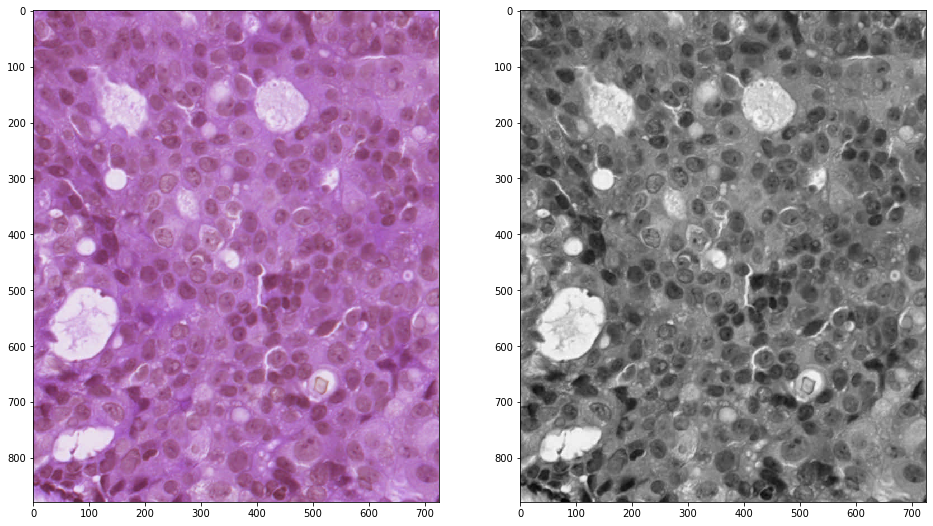

In [10]:
image_fns = sorted(next(os.walk(IMAGES_DEST))[2])

image = skimage.io.imread(os.path.join(IMAGES_DEST, image_fns[random.randrange(len(image_fns))]))

# Get locations
x_pos, y_pos, cells = sliding_window(image, 8, (64, 64))

# Array for storing predictions
pred = np.zeros((image.shape[0], image.shape[1]))

for (x, y, cell) in tqdm(zip(x_pos, y_pos, cells)):
    
    # Get patch
    patch = image[y:y + 64, x:x + 64]
    
    # Get size
    raw_dim = (patch.shape[1], patch.shape[0]) # W, H
    #print(raw_dim)
    #print(patch.shape)
    
    
    if raw_dim != (64, 64):
        
        
        # Resize to 64x64
        patch = cv2.resize(patch, (64, 64), interpolation = cv2.INTER_AREA)
        
        
        # Do stuffffff
        processed = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
        
        
        # Resize back to original shape
        processed = cv2.resize(processed, raw_dim, interpolation = cv2.INTER_AREA)
    
    else:
        
        # Do stuffffff
        processed = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
    
    
    # Add in dummy image
    pred[y:y + 64, x:x + 64] = processed    

print(image.shape, pred.shape)
process(image, pred)